In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import os
import pandas as pd
import numpy as np
from torchinfo import summary
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import wfdb
import seaborn as sns
import matplotlib.patheffects as path_effects

In [2]:
seed = 100
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
torch.manual_seed(seed)
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True

In [3]:
class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_path = root_dir
        self.alldata = np.load(self.root_path) 
        
    def __len__(self):
        return len(self.alldata)
    
    def __getitem__(self, index):
        data = self.alldata[index].reshape((1, 1, 512))
        return data

In [4]:
# model for 8x1 filter, 512 shape
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.ConstantPad2d((3, 3), 0),
            nn.Conv2d(1, 40, (1, 8), (1, 2)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.ConstantPad2d((3, 3), 0),            
            nn.Conv2d(40, 20, (1, 8), (1, 2)),
            nn.BatchNorm2d(20),
            nn.ELU(),       
            nn.ConstantPad2d((3, 3), 0),            
            nn.Conv2d(20, 20, (1, 8), (1, 2)),
            nn.BatchNorm2d(20),
            nn.ELU(),            
            nn.ConstantPad2d((3, 3), 0),            
            nn.Conv2d(20, 40, (1, 8), (1, 2)),
            nn.BatchNorm2d(40),
            nn.ELU(),            
            nn.ConstantPad2d((4, 3), 0),            
            nn.Conv2d(40, 1, (1, 8), (1, 1)),
            nn.BatchNorm2d(1),
            nn.ELU(),        
        )
           
        self.decoder = nn.Sequential(
            nn.ConstantPad2d((1, 0, 4, 4), 0),        
            nn.ConvTranspose2d(1, 1, (1, 8), (1, 1), padding=4),
            nn.BatchNorm2d(1),
            nn.ELU(),            
             nn.ConstantPad2d((1, 0, 4, 4), 0),             
            nn.ConvTranspose2d(1, 40, (1, 8), (1, 2), padding=4),
            nn.BatchNorm2d(40),
            nn.ELU(),        
            nn.ConstantPad2d((1, 0, 4, 4), 0),            
            nn.ConvTranspose2d(40, 20, (1, 8), (1, 2), padding=4),
            nn.BatchNorm2d(20),
            nn.ELU(),                 
            nn.ConstantPad2d((1, 0, 4, 4), 0),            
            nn.ConvTranspose2d(20, 20, (1, 8), (1, 2), padding=4),
            nn.BatchNorm2d(20),
            nn.ELU(),  
            nn.ConstantPad2d((1, 0, 4, 4), 0),            
            nn.ConvTranspose2d(20, 40, (1, 8), (1, 2), padding=4),
            nn.BatchNorm2d(40),
            nn.ELU(),        
            nn.ConstantPad2d((4, 3), 0),             
            nn.Conv2d(40, 1, (1, 8), 1), 
        )     

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
test_data = CustomDataset("../data/p013136-2133-11-09-16-58-data.npy")
test_dataloader = DataLoader(test_data, batch_size=1)

In [6]:
len(test_data)

17315

In [7]:
def PRD(y_true, y_pred):
    y_true, y_pred = y_true.detach().numpy()[0].reshape(512, 1), y_pred.detach().numpy()[0].reshape(512, 1)
    return np.sqrt( np.square(y_true-y_pred).sum() / (np.square(y_true).sum()) ) * 100

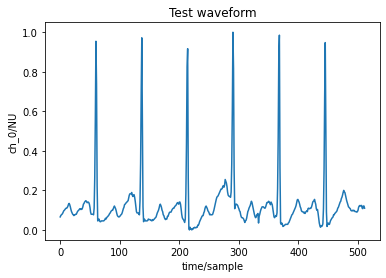

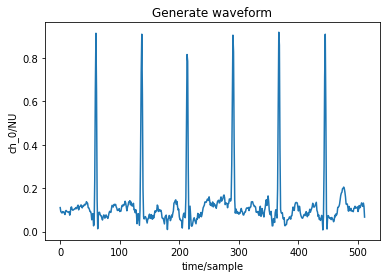

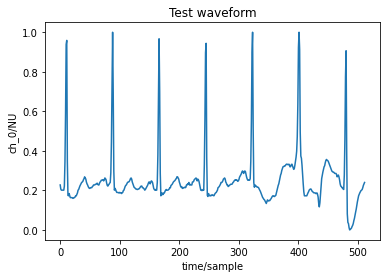

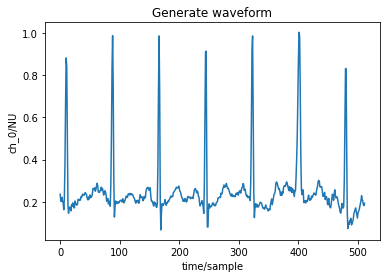

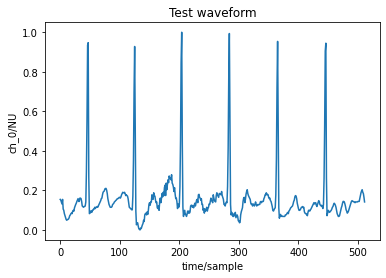

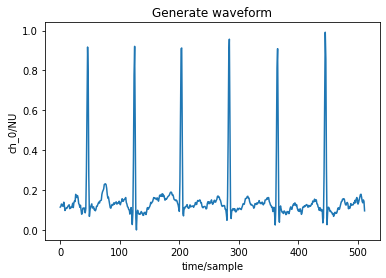

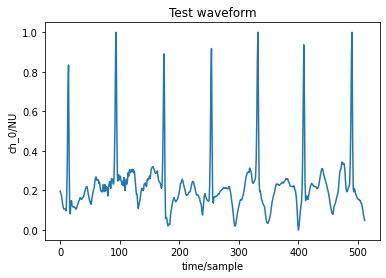

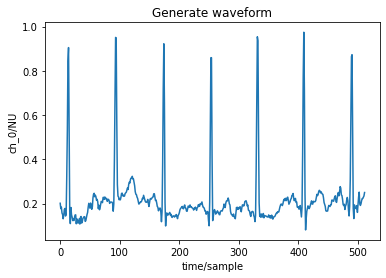

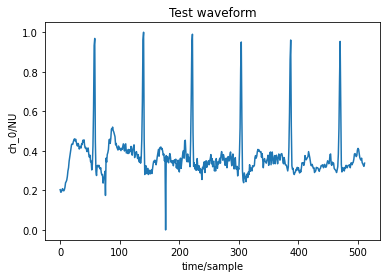

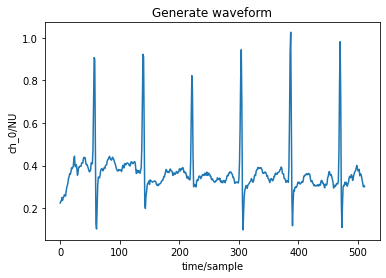

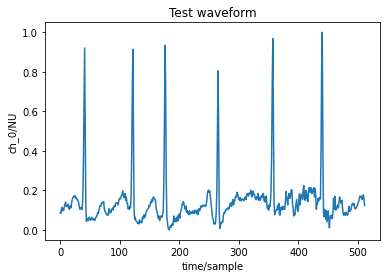

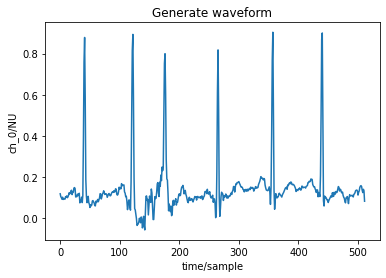

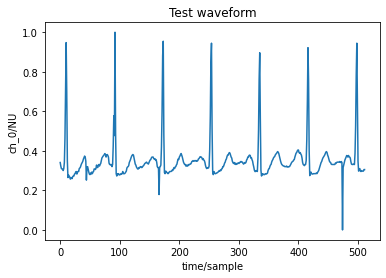

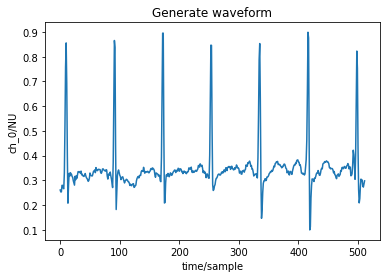

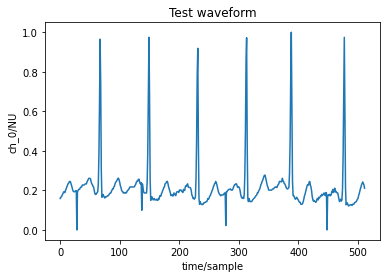

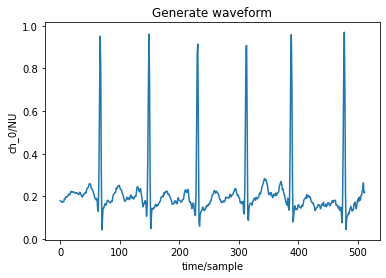

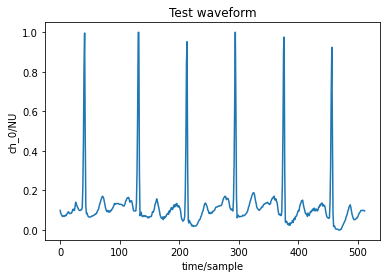

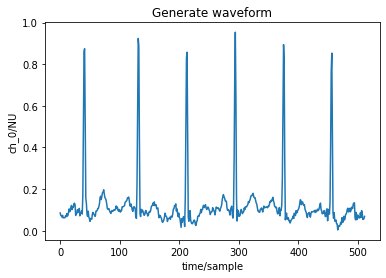

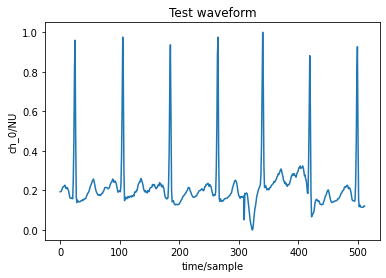

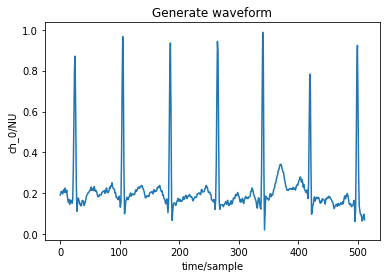

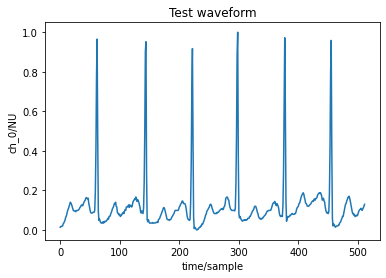

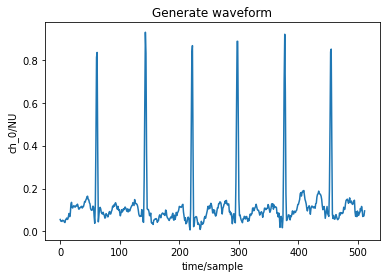

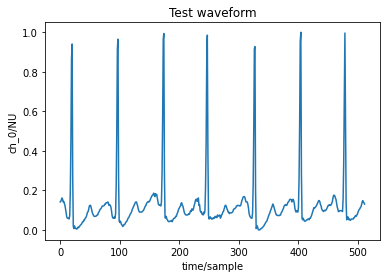

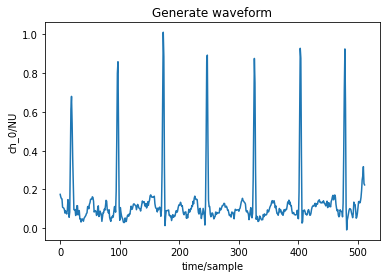

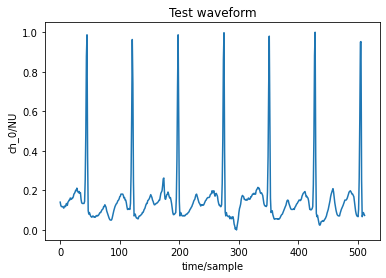

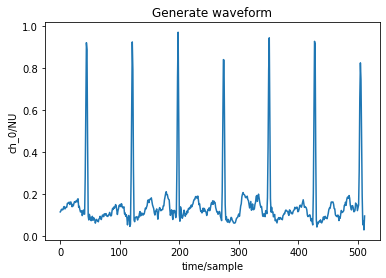

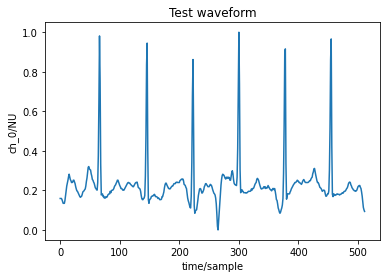

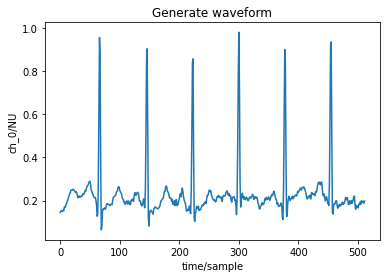

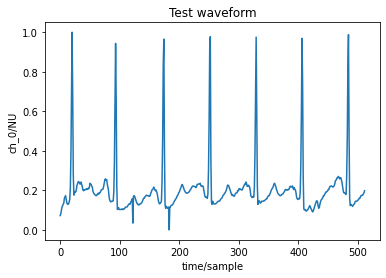

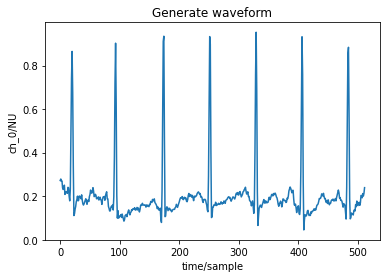

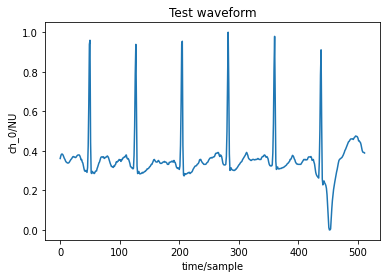

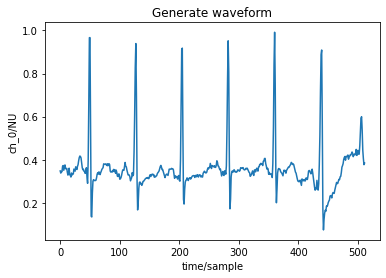

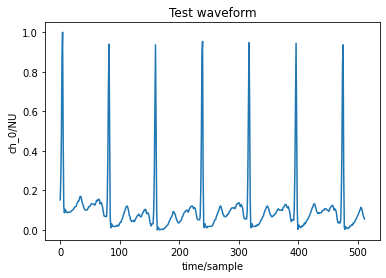

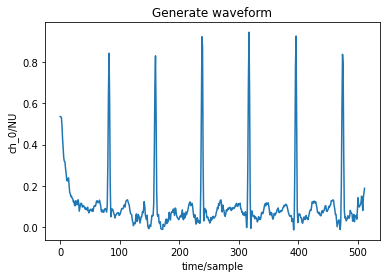

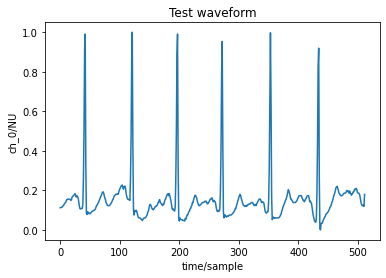

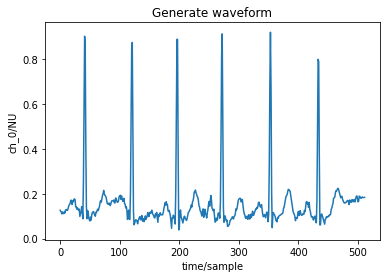

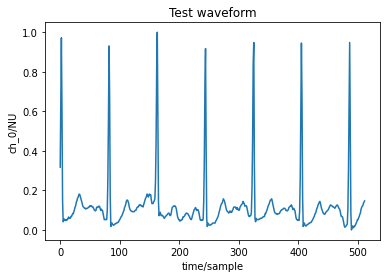

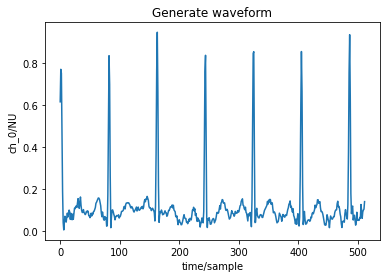

In [8]:
plt.rcParams['figure.figsize'] = [20, 8]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Autoencoder()
loaded = torch.load('../model/FCVE_single_epoch200.pt', map_location=device)
net.load_state_dict(loaded)
net.eval()
testing_loss = []
PRD_list = []
for i, batch in enumerate(test_dataloader):
    if i < 100 and i > 80:
        img1 = batch.numpy().reshape(512, 1)
        wfdb.plot_items(signal=img1, fs=128, title='Test waveform')

    output = net(batch.to(dtype=torch.float))
    
    criterion = nn.MSELoss()
    temp = criterion(output, batch).item()
    testing_loss.append(temp)
    PRD_list.append(PRD(batch, output))    
    
    if i < 100 and i > 80:
        out = output.detach().numpy()[0].reshape(512, 1)
        wfdb.plot_items(signal=out, fs=128, title='Generate waveform')
    

mean loss: nan, max_loss: nan, 75% percentile: nan


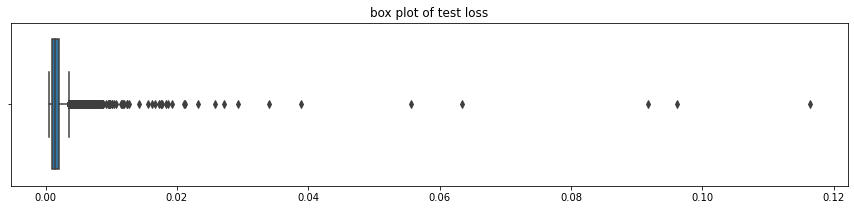

In [9]:
plt.rcParams['figure.figsize'] = [15, 3]
mean_loss = np.mean(testing_loss)
max_loss = np.max(testing_loss)
percent_75 = np.percentile(testing_loss, 75)
ax = sns.boxplot(x=testing_loss).set(title = 'box plot of test loss')
print("mean loss: {}, max_loss: {}, 75% percentile: {}".format(mean_loss, max_loss, percent_75))

In [10]:
def add_median_labels(ax, fmt='.1f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

17.950325988926643 15.394251949778782 19.785240171124762 80.0 8.593050231251281


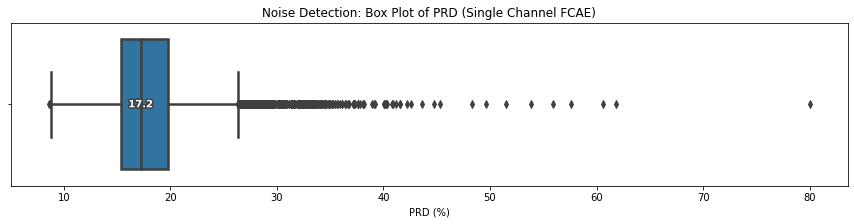

In [11]:
plt.rcParams['figure.figsize'] = [15, 3]
PRD_list_withoutnan = np.nan_to_num(PRD_list, nan=80, posinf=100)
single_PRD_box = sns.boxplot(x=PRD_list_withoutnan, linewidth=2.5)
single_PRD_box.set(title = 'Noise Detection: Box Plot of PRD (Single Channel FCAE)')
single_PRD_box.set(xlabel='PRD (%)')
add_median_labels(single_PRD_box)
fig = single_PRD_box.get_figure()
print(np.mean(PRD_list_withoutnan), np.percentile(PRD_list_withoutnan, 25), np.percentile(PRD_list_withoutnan, 75), np.max(PRD_list_withoutnan), np.min(PRD_list_withoutnan)) 

  label  lower_whisker  lower_quartile    median  upper_quartile  \
0  data       8.809791       15.394252  17.22357        19.78524   

   upper_whisker  
0      26.366105  


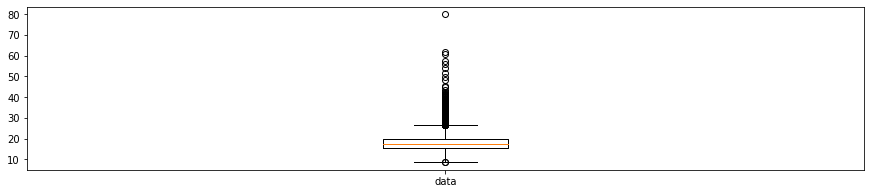

In [12]:
data = PRD_list_withoutnan
def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

labels = ['data']
bp = plt.boxplot(PRD_list_withoutnan, labels=labels)
print(get_box_plot_data(labels, bp))
plt.show()

In [14]:
index = np.array(np.where(PRD_list_withoutnan>40))
index

array([[    0,    22,   264,   282,   842,  1391,  2394,  2595,  2677,
         2916,  3232,  3488,  3489,  7451,  9245, 13342, 13696, 17031,
        17032, 17033, 17034, 17035, 17036, 17037]], dtype=int64)

0: Calculated test loss: nan, PRD: nan


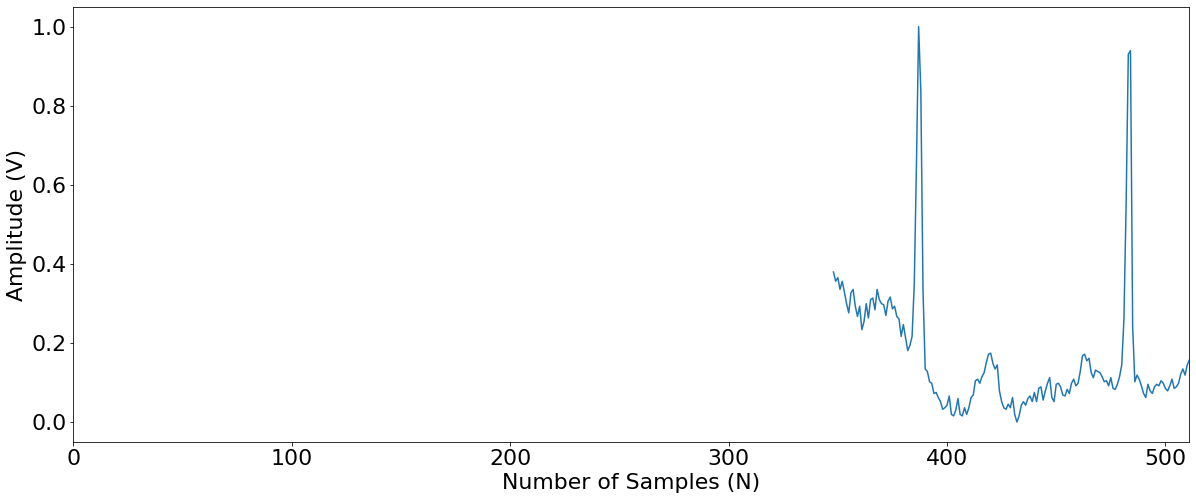

22: Calculated test loss: 0.006477, PRD: 40.80756974521402


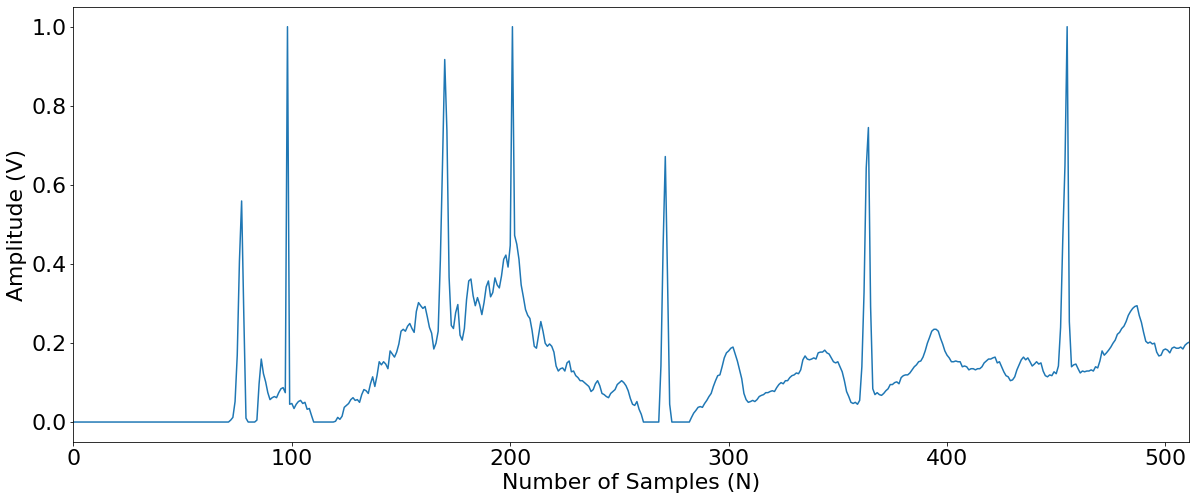

264: Calculated test loss: 0.009778, PRD: 41.55482660184017


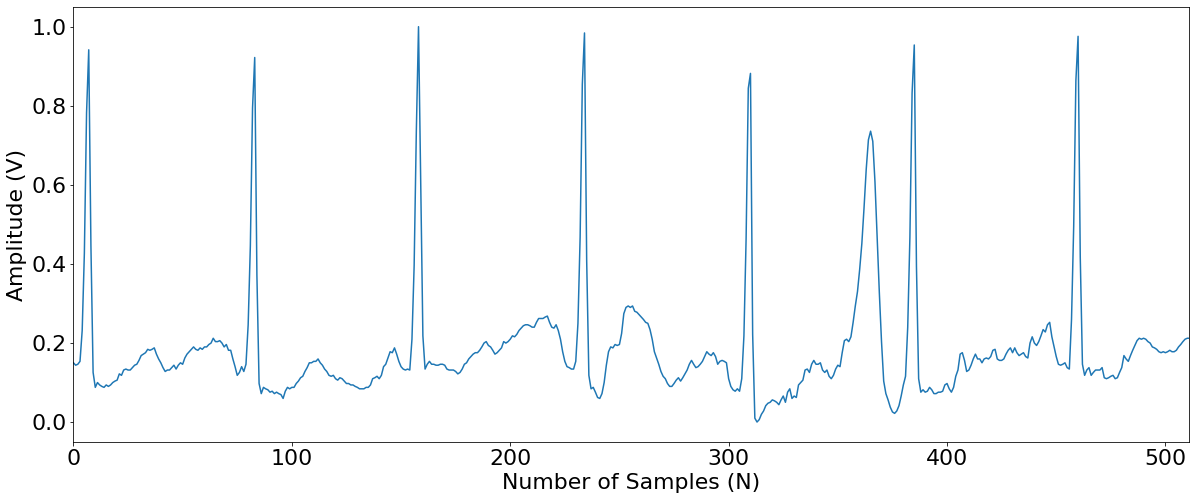

282: Calculated test loss: 0.011648, PRD: 42.206687574955716


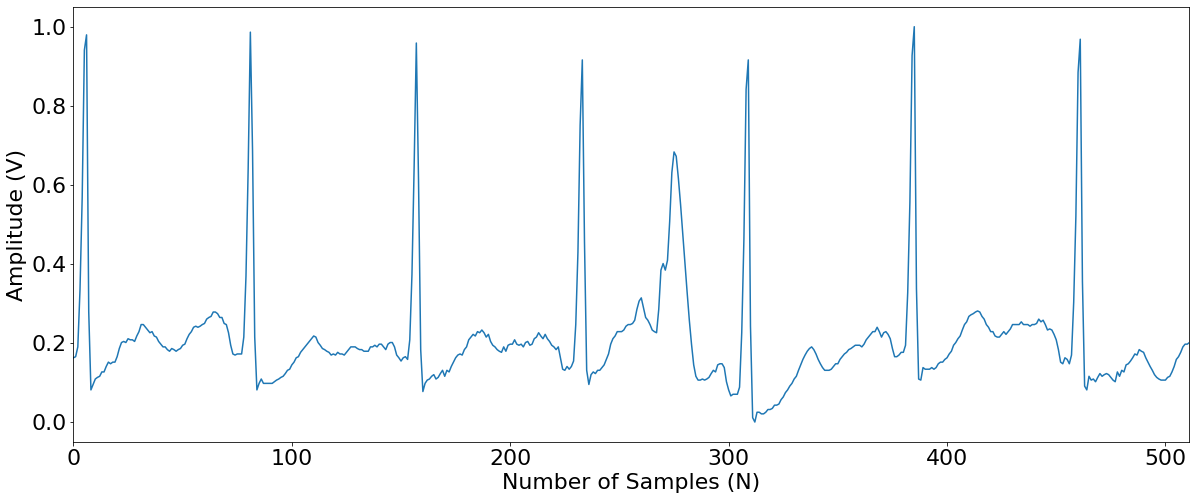

842: Calculated test loss: 0.017336, PRD: 53.81413312490518


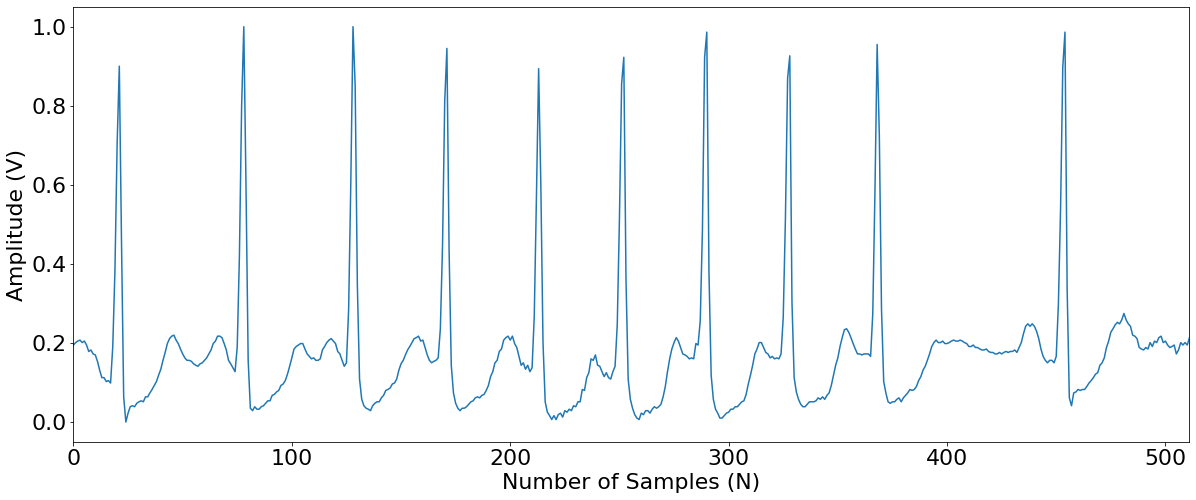

1391: Calculated test loss: 0.009654, PRD: 45.28842783858157


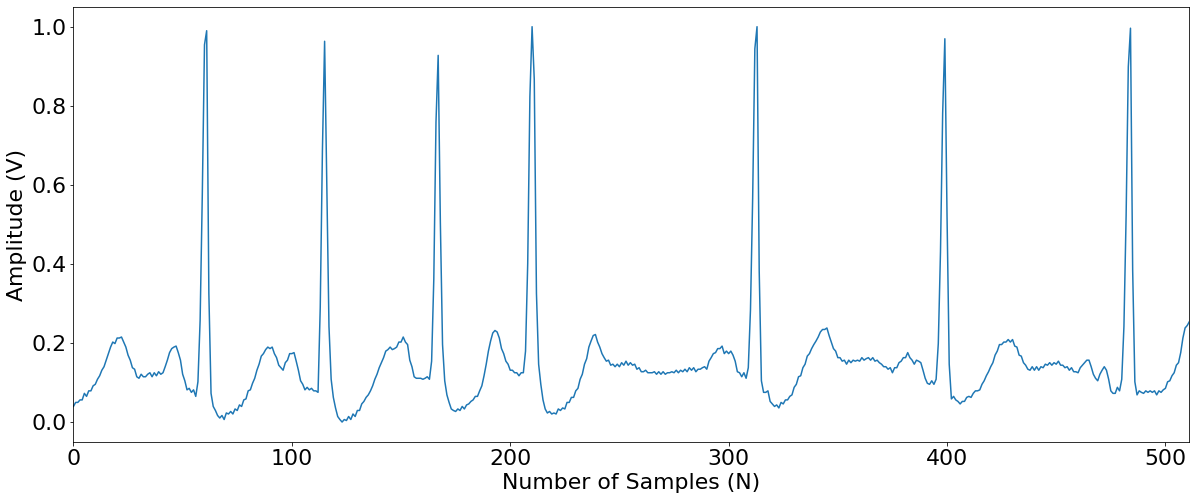

2394: Calculated test loss: 0.006376, PRD: 40.032163641593534


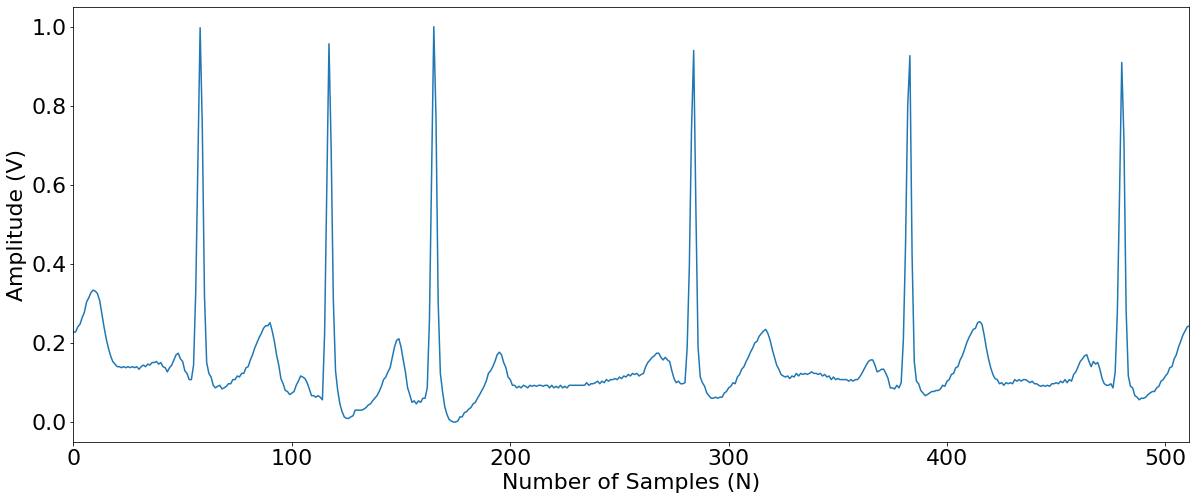

2595: Calculated test loss: 0.010448, PRD: 49.64159214342349


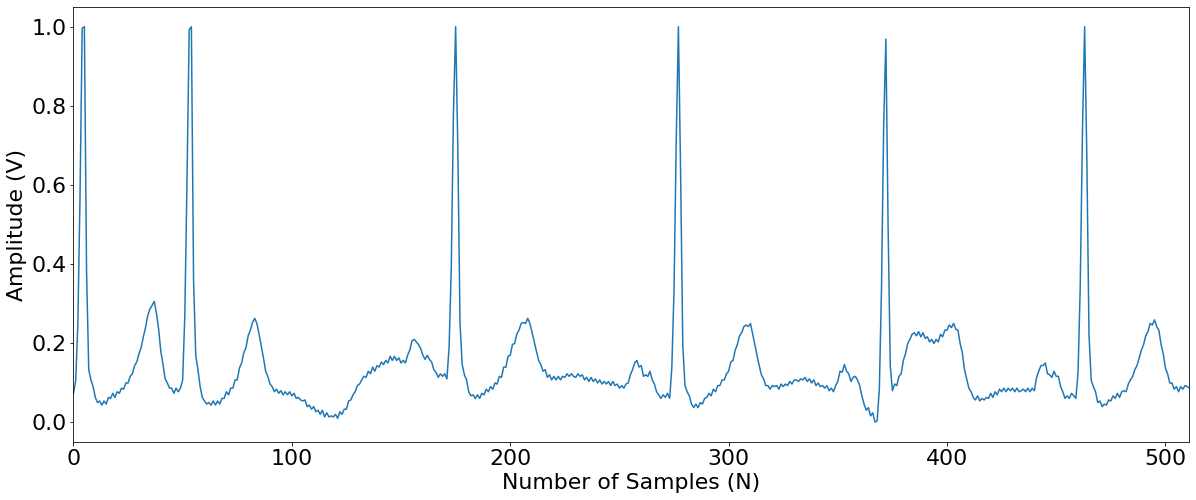

2677: Calculated test loss: 0.006164, PRD: 42.57197822233795


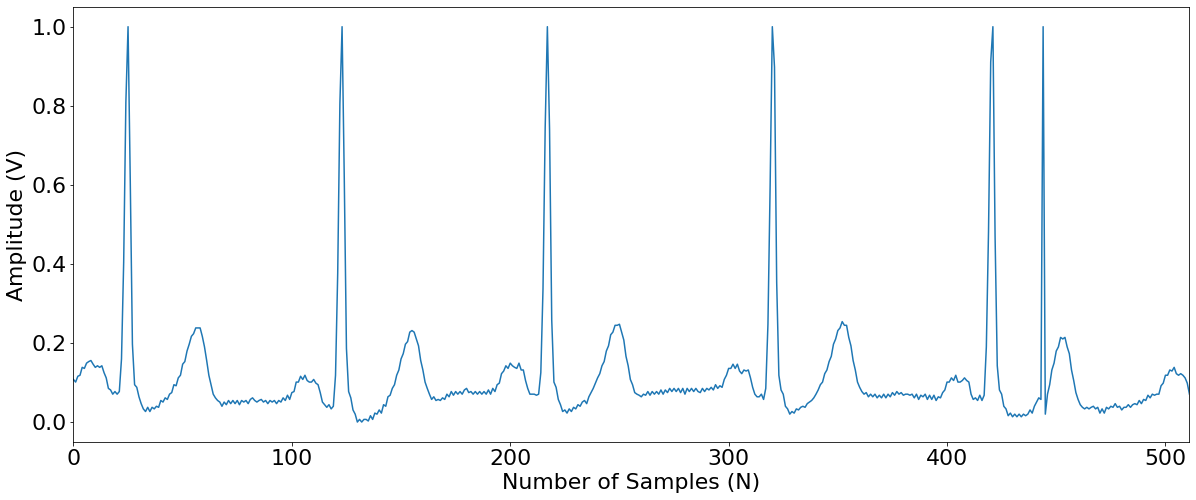

2916: Calculated test loss: 0.007928, PRD: 41.517549233314725


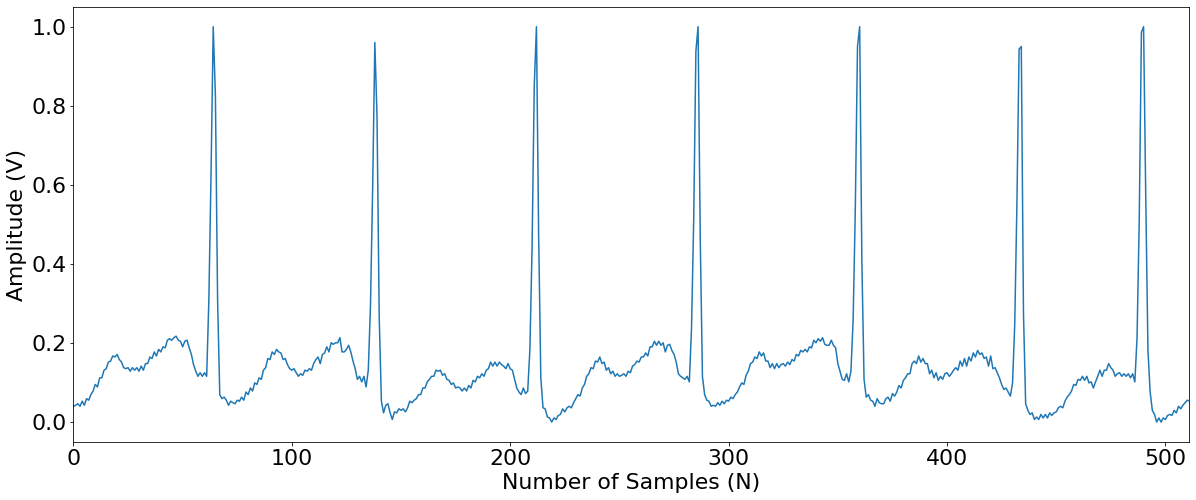

3232: Calculated test loss: 0.008667, PRD: 40.02285953860352


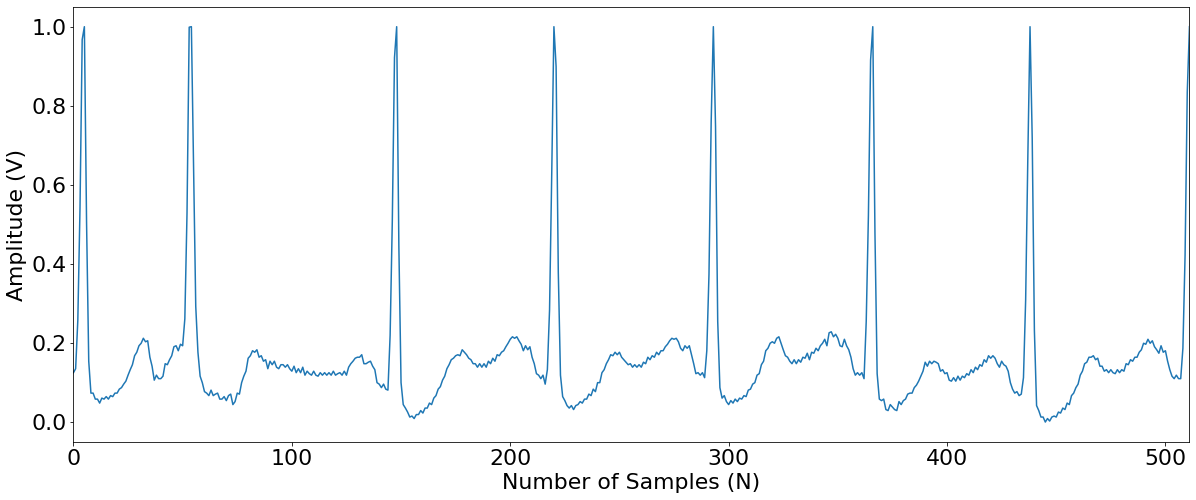

3488: Calculated test loss: 0.011484, PRD: 44.73240851774945


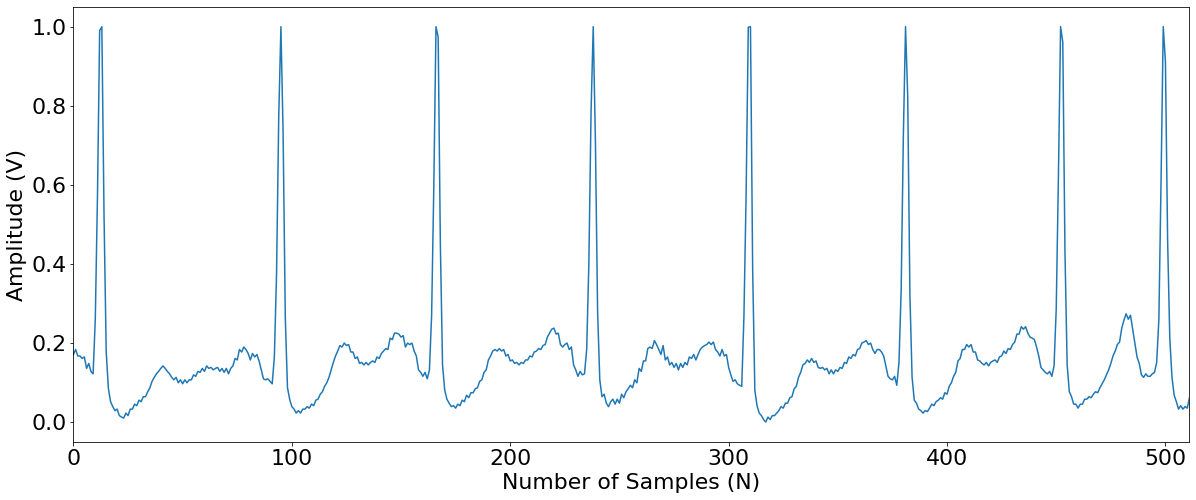

3489: Calculated test loss: 0.007959, PRD: 40.31874453461128


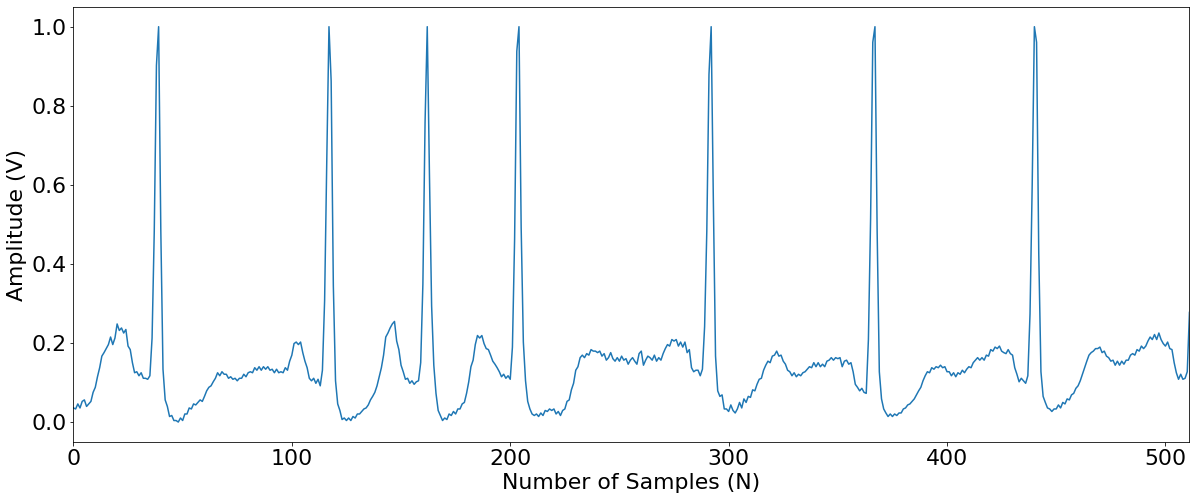

7451: Calculated test loss: 0.007845, PRD: 40.932478545625294


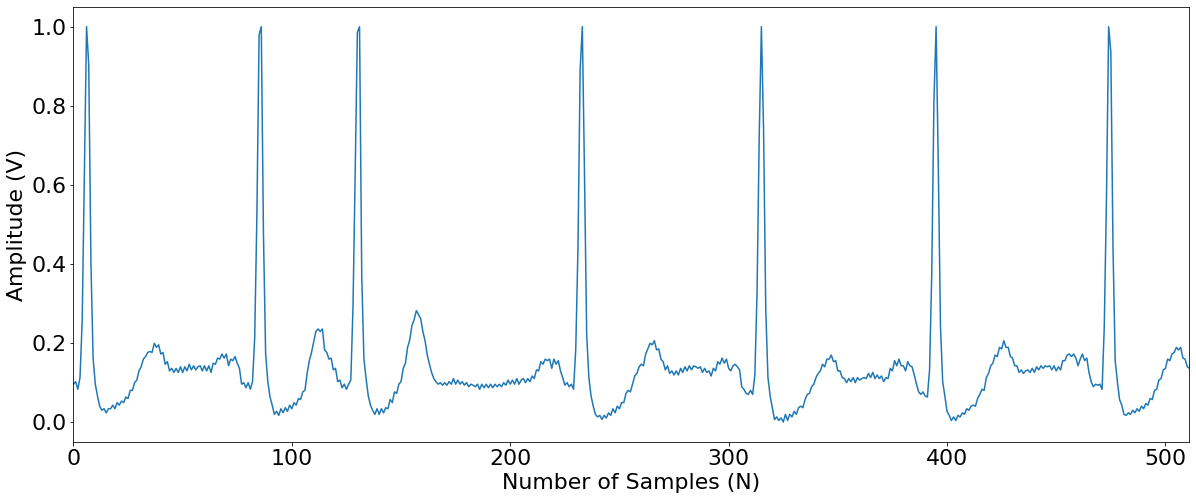

9245: Calculated test loss: 0.009228, PRD: 40.138057185939196


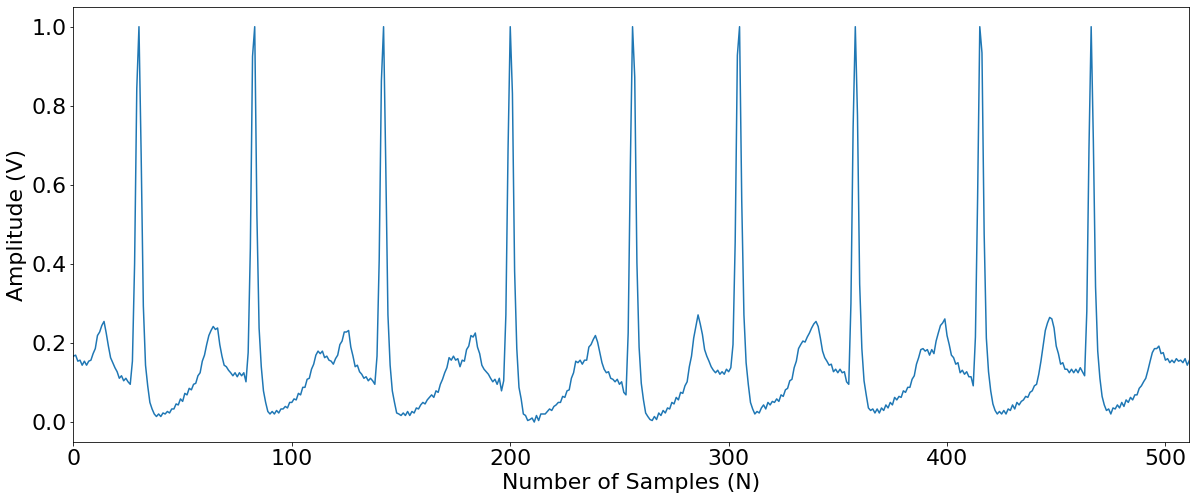

13342: Calculated test loss: 0.019248, PRD: 51.50630016415867


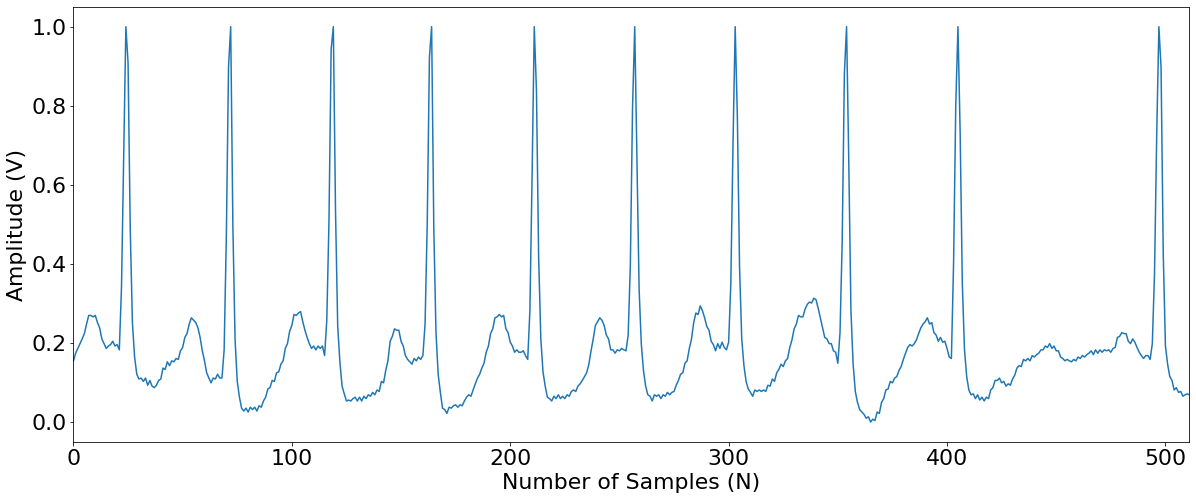

13696: Calculated test loss: 0.034046, PRD: 41.2269436933772


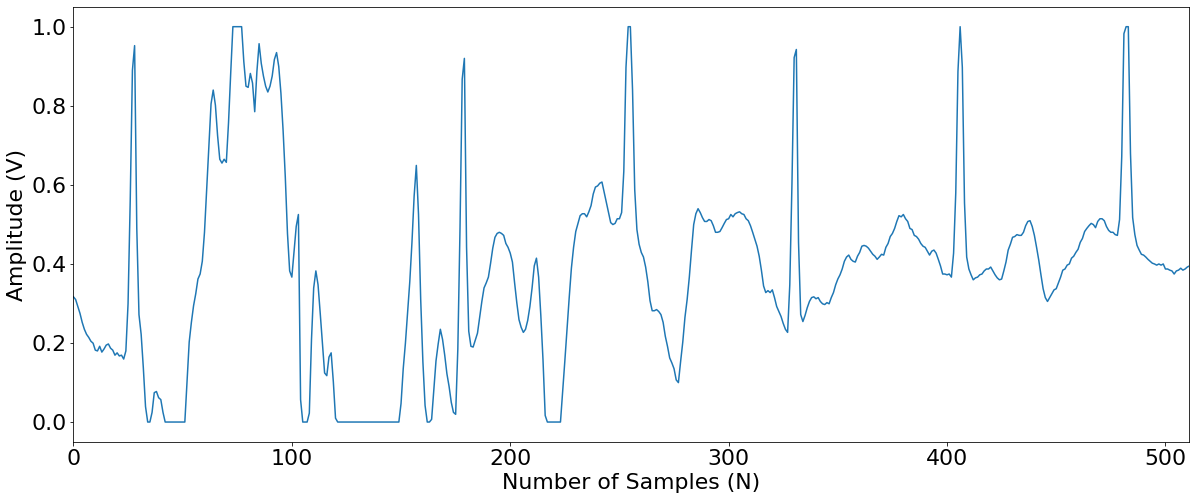

17031: Calculated test loss: 0.063420, PRD: 48.33491318881289


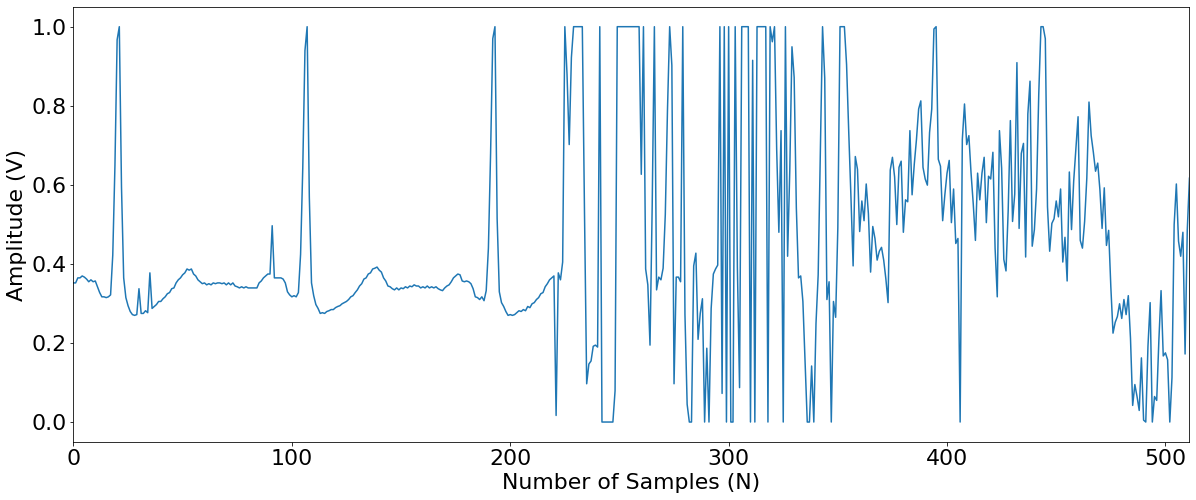

17032: Calculated test loss: 0.096202, PRD: 57.60795563541471


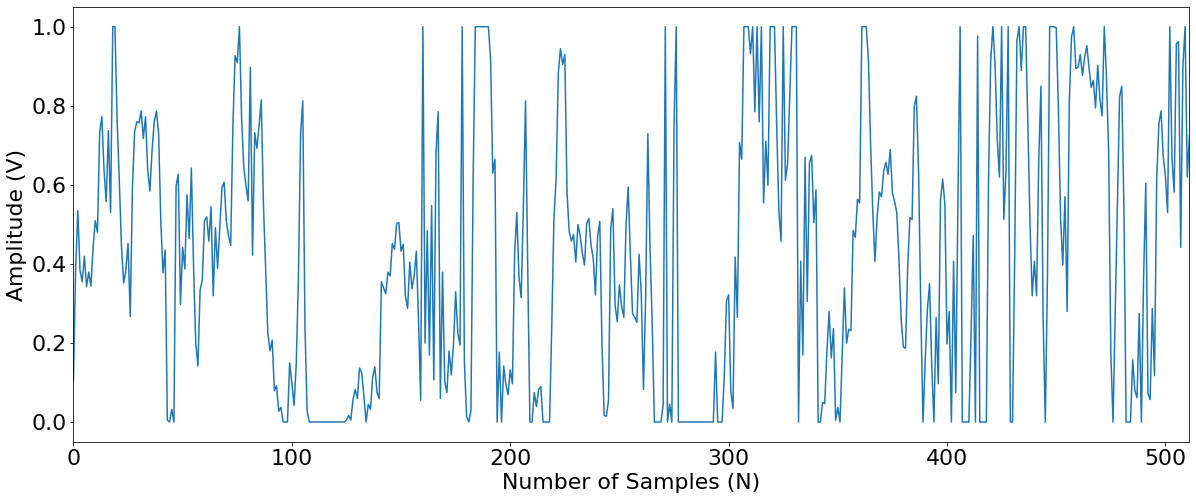

17033: Calculated test loss: 0.091690, PRD: 60.650436946302946


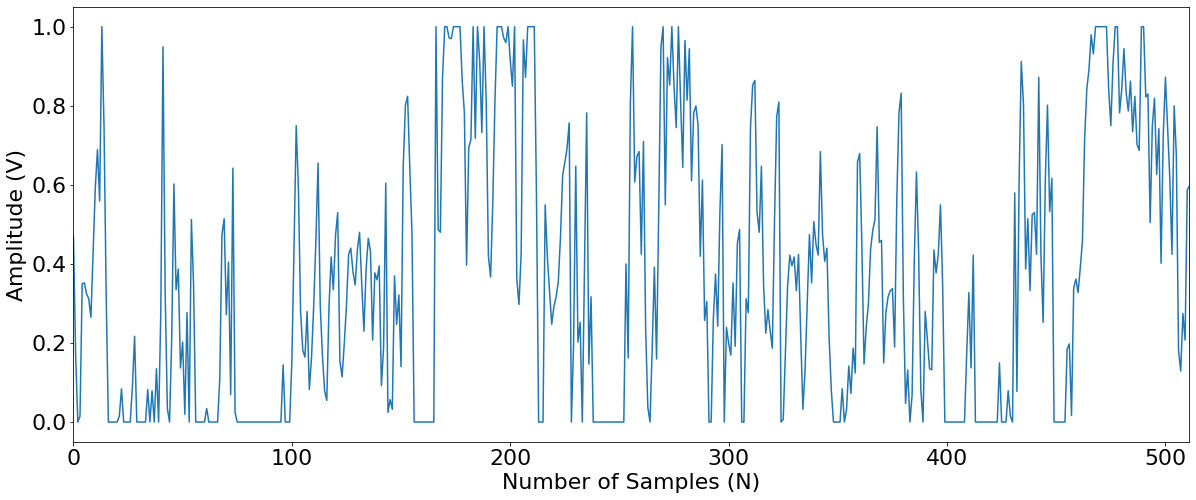

17034: Calculated test loss: 0.055594, PRD: 55.89039824942606


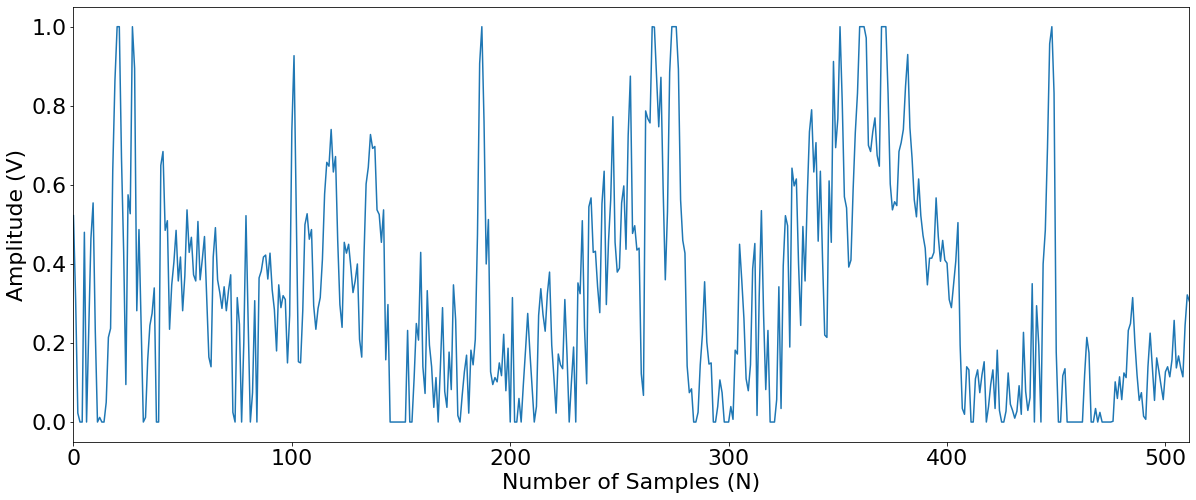

17035: Calculated test loss: 0.038899, PRD: 43.59605698370034


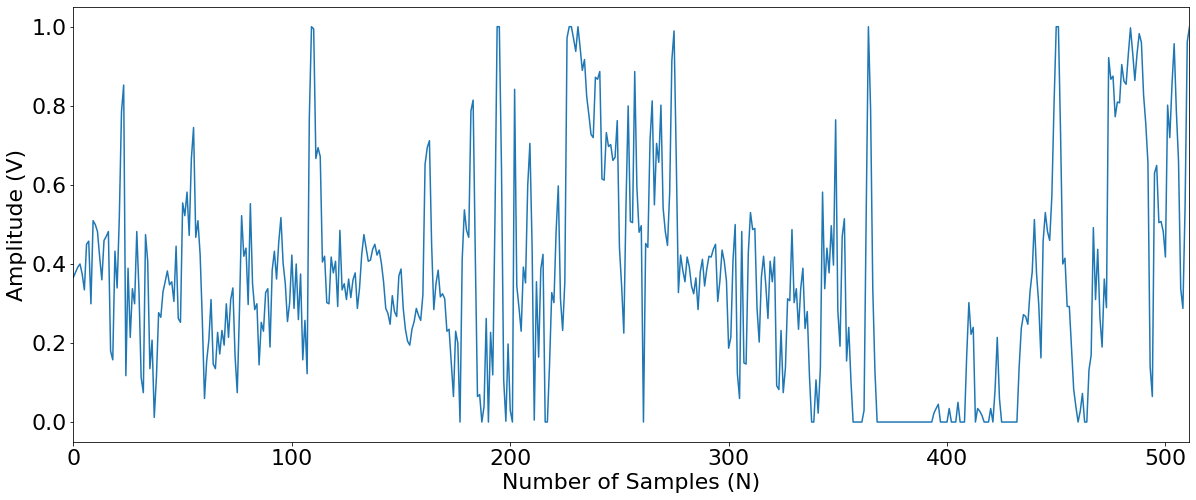

17036: Calculated test loss: 0.116346, PRD: 61.79846498015233


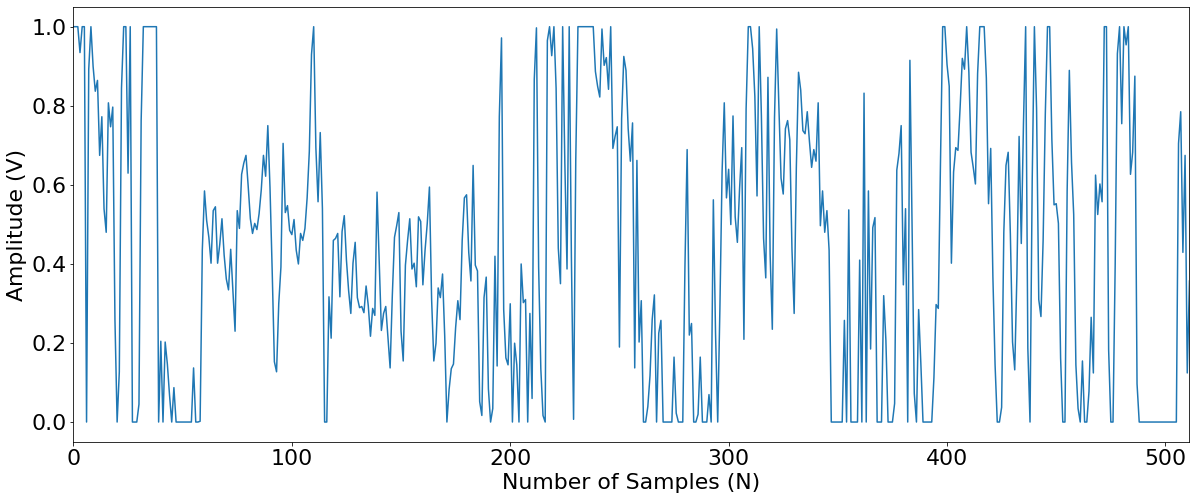

17037: Calculated test loss: 0.025721, PRD: 40.198146538675275


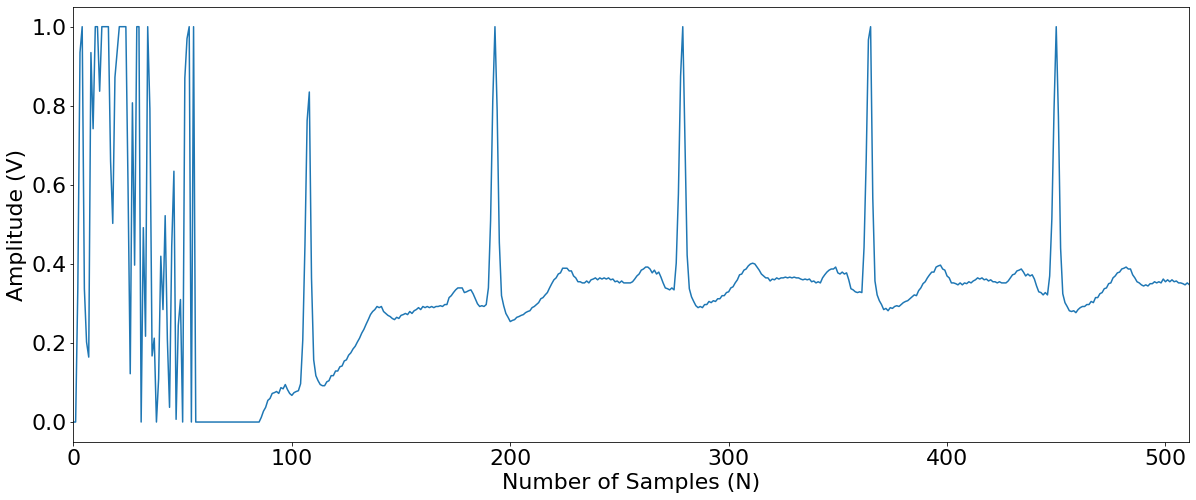

In [16]:
plt.rcParams['figure.figsize'] = [20, 8]
for i, batch in enumerate(test_dataloader):
    if i in index:
        img1 = batch.numpy().reshape(512, 1)
        output = net(batch.to(dtype=torch.float))
        criterion = nn.MSELoss()
        temp = criterion(output, batch).item()
        out = output.detach().numpy()[0].reshape(512, 1)
        
        print("{}: Calculated test loss: {:3.6f}, PRD: {}".format(i, float(temp), PRD(batch, output)))
    
        x = [i for i in range(512)]
        f = plt.figure()
        plt.plot(x, img1, label='Original')
        plt.xlim(xmin=0)
        plt.xlim(xmax=len(x)-1)    
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=22)
        plt.xlabel('Number of Samples (N)', fontsize=22)
        plt.ylabel('Amplitude (V)', fontsize=22)
        plt.show() 